In [35]:
import numpy as np
import pandas as pd



def print_prime_mover_description(string, prime_mover_codes):
    description = prime_mover_codes.loc[prime_mover_codes['Prime Mover Codes'] == string, 'Description'].values
    if len(description) > 0:
        print(description[0])
    else:
        print("No description found for the given string.")

def print_fuel_codes_description(string, fuel_codes):
    description = fuel_codes.loc[fuel_codes['Energy Source Code'] == string, 'Description'].values
    if len(description) > 0:
        print(description[0])
    else:
        print("No description found for the given string.")

def get_fuel_mover(data, fuel, mover):
    return data[(data['Energy_Source_1 (Fuel)'] == fuel) & (data['PRIMEMOVER'] == mover)]



## Data processing

In [36]:
# Get the sheet names
excel_file = pd.ExcelFile('ferc_data\\20120724-4012_Generator_Data_Summer.xlsx')
sheet_names = excel_file.sheet_names

# Create a dictionary to store the separated dataframes
separated_dataframes = {}

# Iterate over each sheet and store the data in the dictionary
for sheet_name in sheet_names:
    separated_dataframes[sheet_name] = excel_file.parse(sheet_name)

# Process for Cleaning Generator Characteristics
gen_characteristics = separated_dataframes['Generator Characteristics']
gen_characteristics.columns = separated_dataframes['Generator Characteristics'].iloc[0]
gen_characteristics.drop(0, inplace=True)
gen_characteristics.reset_index(drop=True, inplace=True)
# gen_characteristics.drop_duplicates(gen_characteristics.columns[duplicate_index], axis=1)
gen_characteristics= gen_characteristics.loc[:,~gen_characteristics.columns.duplicated()].copy()

# Process for Cleaning Generator costs
gen_costs = separated_dataframes['Generator Offer Curve'].iloc[:,24:28]
gen_costs.columns = gen_costs.iloc[1]
gen_costs.drop([0,1], inplace=True)
gen_costs.reset_index(drop=True, inplace=True)
gen_costs.rename(columns={'1': 'index'}, inplace=True)
gen_costs.rename(columns={np.nan: 'Generic Name'}, inplace=True)

In [37]:
# the important paramaters are:
key_params = ['NAMEPLATE (MWs)','RAMP UP (MW/min)', 'RAMP DOWN (MW/min)', 'Economic Minimum (MW)', 'MIN_DOWN_TIME (hr)', 'MIN_RUN_TIME (hr)']

In [38]:
import matplotlib.pyplot as plt

def print_param_plots(new_df, mover, fuel):
    # Exclude the 'NAMEPLATE (MWs)' column from the list of columns
    columns = new_df.columns.drop('NAMEPLATE (MWs)')

    # Create subplots for each column
    fig, axes = plt.subplots(len(columns), 1, figsize=(10, 8))

    # Iterate over each column and plot against 'NAMEPLATE (MWs)'
    for i, column in enumerate(columns):
        axes[i].scatter(new_df['NAMEPLATE (MWs)'], new_df[column])
        axes[i].set_xlabel('NAMEPLATE (MWs)')
        axes[i].set_ylabel(column)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Add a title to the entire figure
    fig.suptitle('Mover: {} and Fuel: {}'.format(mover, fuel), fontsize=16)

    # Show the plot
    plt.show()

Note that ramping is in MW/min and needs to be % of MW capacity /hr

In [39]:
ramp_params = ['RAMP UP (MW/min)', 'RAMP DOWN (MW/min)']
capacity_param = ['NAMEPLATE (MWs)']

# Divide each row of ramp_params by NAMEPLATE (MWs) and multiply by 60 to convert to per hour
percent_ramp =  gen_characteristics[ramp_params].div(gen_characteristics['NAMEPLATE (MWs)'], axis=0) * 60
gen_characteristics[ramp_params] = percent_ramp

# change the name of the columns to reflect the change in units for ramping
gen_characteristics.rename(columns={'RAMP UP (MW/min)': 'PERC RAMP UP', 'RAMP DOWN (MW/min)': 'PERC RAMP DOWN'}, inplace=True)

# update key param names
key_params = ['NAMEPLATE (MWs)','PERC RAMP UP', 'PERC RAMP DOWN', 'Economic Minimum (MW)', 'MIN_DOWN_TIME (hr)', 'MIN_RUN_TIME (hr)']

In [40]:
def print_summary_statistics(new_df):

    # Calculate mean of all columns
    mean_values = new_df.mean()

    # Calculate variance of all columns
    variance_values = new_df.var()

    # Calculate minimum of all columns
    minimum_values = new_df.min()

    # Calculate maximum of all columns
    maximum_values = new_df.max()

    # Calculate median of all columns
    median_values = new_df.median()

    # Create a DataFrame with the calculated values
    summary_df = pd.DataFrame({
        'Mean': mean_values,
        'Variance': variance_values,
        'Minimum': minimum_values,
        'Maximum': maximum_values,
        'Median': median_values
    })

    # Display the summary DataFrame
    print(summary_df)

## Processing Requiring Inputs

In [41]:
# selected fuel types and prime movers
BIT_ST_coal = get_fuel_mover(gen_characteristics, 'BIT', 'ST')
DFO_GT_diesel = get_fuel_mover(gen_characteristics, 'DFO', 'GT')
NG_GT_gas = get_fuel_mover(gen_characteristics, 'NG', 'GT')
NG_CT_gas = get_fuel_mover(gen_characteristics, 'NG', 'CT')
NG_IT_gas = get_fuel_mover(gen_characteristics, 'NG', 'IT')
DFO_IC_diesel = get_fuel_mover(gen_characteristics, 'DFO', 'IC')

In [42]:
BIT_ST_coal_params = BIT_ST_coal.loc[:, key_params]
DFO_GT_diesel_params = DFO_GT_diesel.loc[:, key_params]
NG_GT_gas_params = NG_GT_gas.loc[:, key_params]
NG_CT_gas_params = NG_CT_gas.loc[:, key_params]
NG_IT_gas_params = NG_IT_gas.loc[:, key_params]
DFO_IC_diesel_params = DFO_IC_diesel.loc[:, key_params]

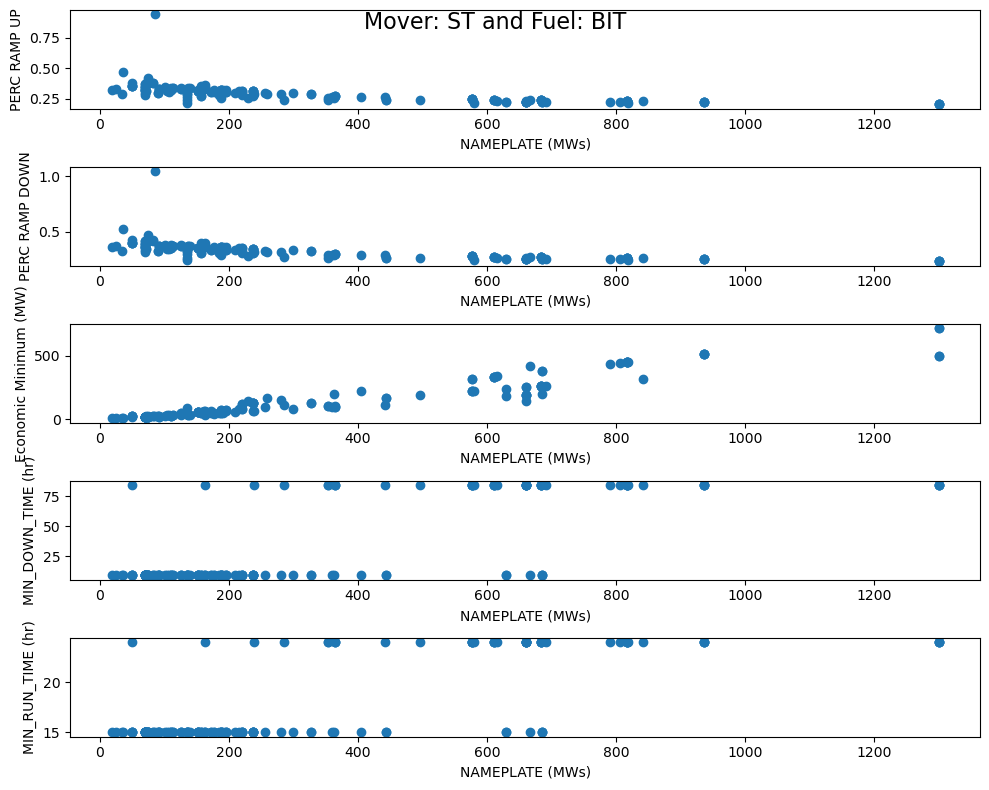

In [43]:
print_param_plots(BIT_ST_coal_params, 'ST', 'BIT')

In [44]:
print_summary_statistics(BIT_ST_coal_params)

                             Mean      Variance   Minimum   Maximum    Median
0                                                                            
NAMEPLATE (MWs)        337.072393  90162.183739        18      1300     196.0
PERC RAMP UP             0.292152      0.005362  0.203408  0.938932  0.293419
PERC RAMP DOWN           0.326875      0.006463  0.231264  1.045423   0.32706
Economic Minimum (MW)  142.512748  23875.907565      6.84       715     71.25
MIN_DOWN_TIME (hr)         33.375   1241.745283         9        84       9.0
MIN_RUN_TIME (hr)          17.925     17.881132        15        24      15.0


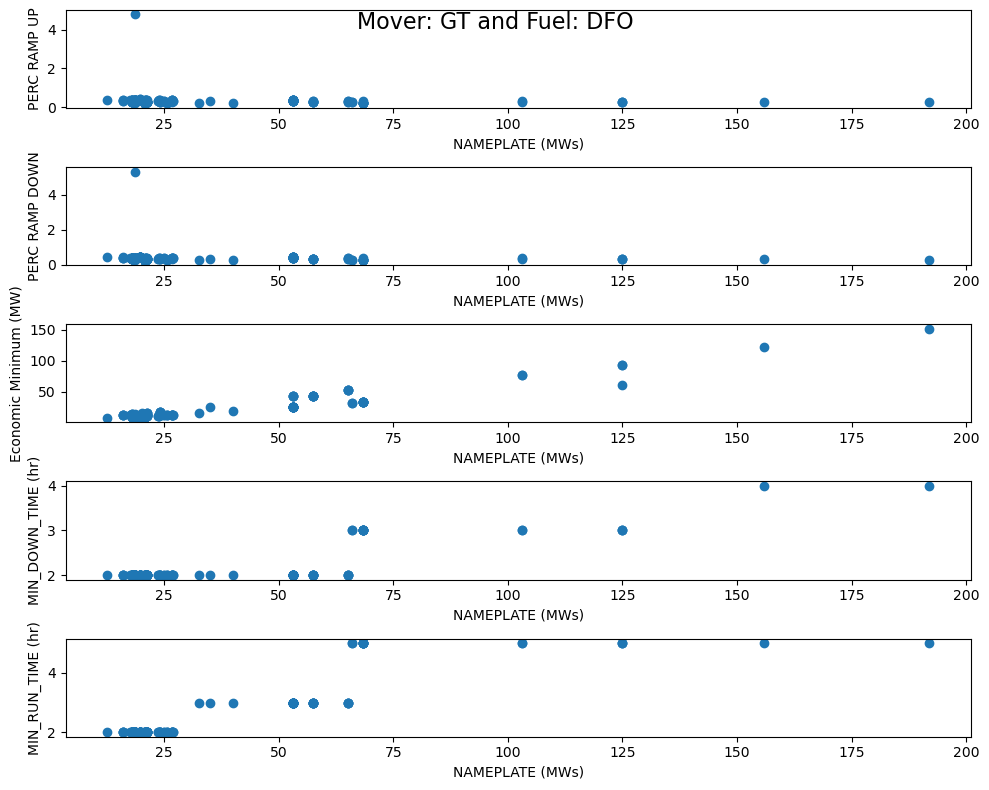

In [45]:
print_param_plots(DFO_GT_diesel_params, 'GT', 'DFO')

In [46]:
print_summary_statistics(DFO_GT_diesel_params)

                            Mean    Variance   Minimum   Maximum    Median
0                                                                         
NAMEPLATE (MWs)        34.148171  755.916224      12.5       192     20.85
PERC RAMP UP            0.343447    0.123364  0.192604  4.771935   0.32115
PERC RAMP DOWN           0.38286    0.152828  0.214757  5.311742  0.358079
Economic Minimum (MW)  20.388829  428.090364      7.75       152    11.662
MIN_DOWN_TIME (hr)      2.115854      0.1276         2         4       2.0
MIN_RUN_TIME (hr)            2.5    0.877301         2         5       2.0


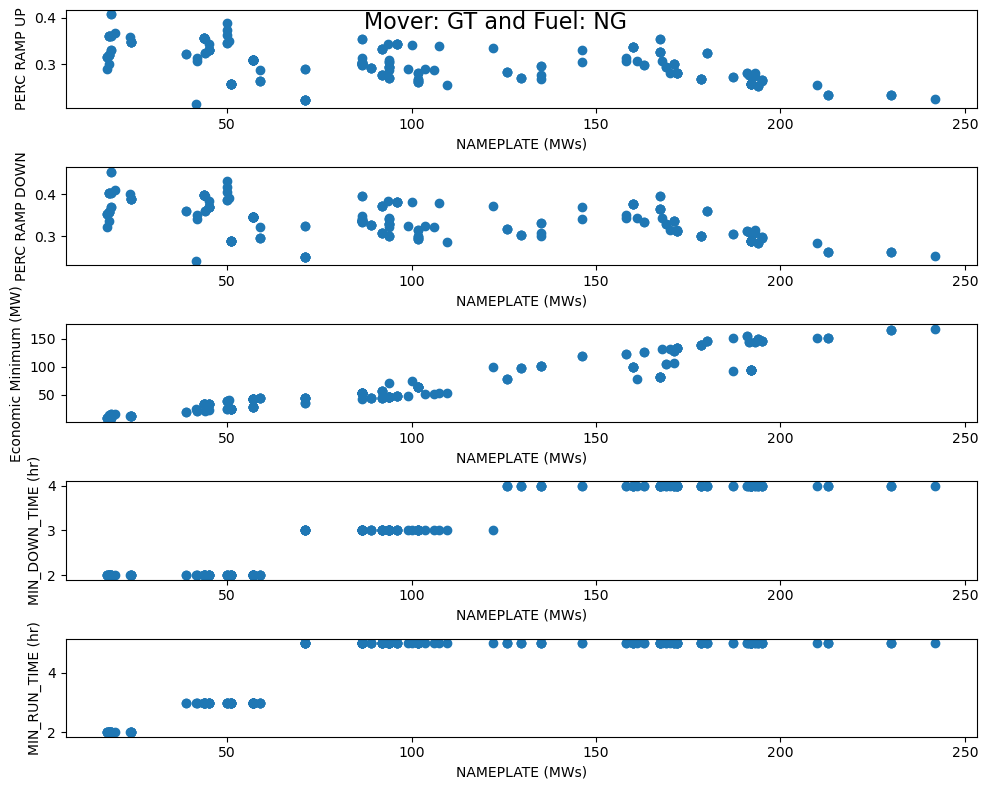

In [47]:
print_param_plots(NG_GT_gas_params, 'GT', 'NG')

In [48]:
print_summary_statistics(NG_GT_gas_params)

                             Mean     Variance   Minimum   Maximum    Median
0                                                                           
NAMEPLATE (MWs)        102.226582  3617.473401      17.5       242      91.9
PERC RAMP UP              0.30134     0.001363  0.216398  0.406611  0.301474
PERC RAMP DOWN           0.335868     0.001696   0.24127  0.453357  0.336041
Economic Minimum (MW)    66.48865  2002.860085     8.575       168    47.089
MIN_DOWN_TIME (hr)       2.974684     0.719695         2         4       3.0
MIN_RUN_TIME (hr)        4.147679     1.312844         2         5       5.0


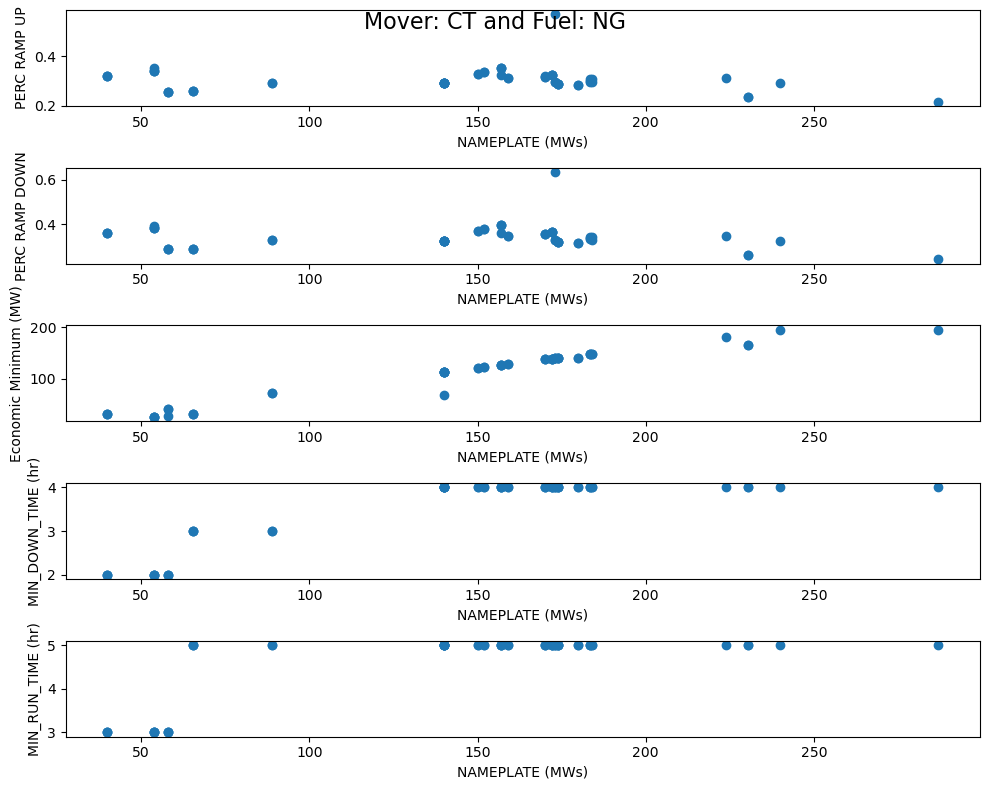

In [49]:
print_param_plots(NG_CT_gas_params, 'CT', 'NG')

In [50]:
print_summary_statistics(NG_CT_gas_params)

                             Mean     Variance   Minimum   Maximum    Median
0                                                                           
NAMEPLATE (MWs)        143.368966  3263.258318        40       287     157.0
PERC RAMP UP             0.306885       0.0022  0.217457  0.569334  0.299821
PERC RAMP DOWN           0.341951     0.002722  0.242225  0.633524  0.334024
Economic Minimum (MW)  111.020897  2358.940219    26.313       195    127.17
MIN_DOWN_TIME (hr)       3.568966     0.600423         2         4       4.0
MIN_RUN_TIME (hr)        4.655172     0.580762         3         5       5.0


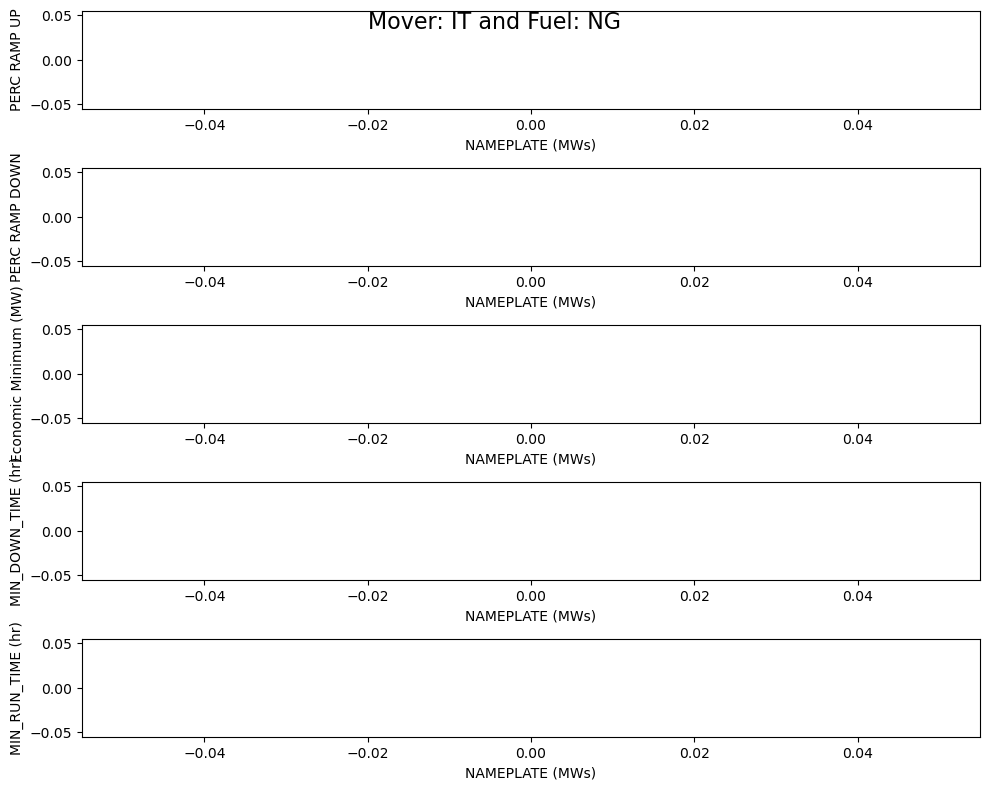

In [51]:
print_param_plots(NG_IT_gas_params, 'IT', 'NG')

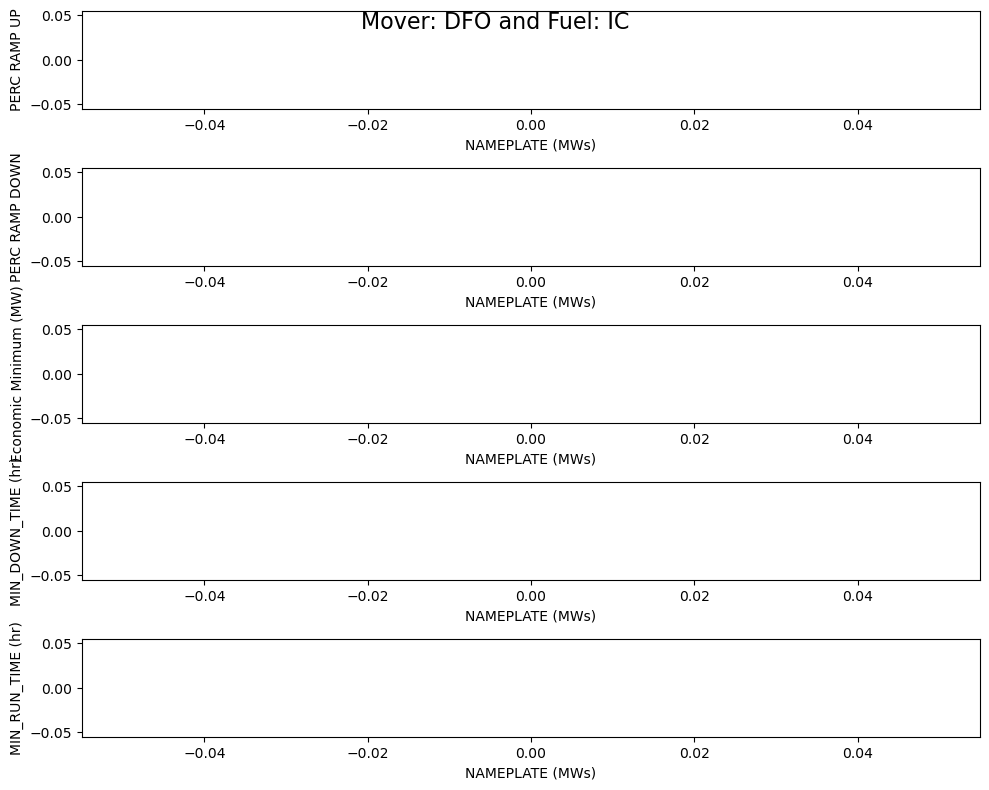

In [63]:
print_param_plots(NG_IT_gas_params, 'DFO', 'IC')

Likely process:
* assume parameters
* run capacity expansion
* calculate MW/generator
* estimate parameters 
* rerun capacity expansion
* check change in MW/generator

OR
* just assume mean for ramp and EcoMin
* assume minimum for up/down

then also, where is this information being output to? i guess i should try to put it directly into the input file.
First i have to correlate the FERC names with the GenX names

Get Cost information

In [52]:
BIT_ST_coal['Generic Name']

5        GEN6
6        GEN7
9       GEN10
10      GEN11
11      GEN12
        ...  
745    GEN746
746    GEN747
760    GEN761
761    GEN762
763    GEN764
Name: Generic Name, Length: 163, dtype: object

In [53]:
# create dataframe from gen_costs where the 'Generic Name' is in the list of generic names from BIT_ST_coal
BIT_ST_coal_costs = gen_costs[gen_costs['Generic Name'].isin(BIT_ST_coal['Generic Name'])]
BIT_ST_coal_costs.drop('Generic Name', axis=1, inplace=True)

C:\Users\ks885\AppData\Local\Temp\ipykernel_5636\692615066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BIT_ST_coal_costs.drop('Generic Name', axis=1, inplace=True)


In [54]:
# print descriptive statistics for the cost data
print_summary_statistics(BIT_ST_coal_costs)

                             Mean           Variance   Minimum       Maximum  \
1                                                                              
No Load Cost ($)       997.306133     2491067.800468  0.007058  13190.010409   
Cold Start Cost ($)  19673.141288  1299083566.478814         0     222301.23   
Hot Start Cost ($)   10331.615706   328916331.742331         0      96752.78   

                         Median  
1                                
No Load Cost ($)     560.309854  
Cold Start Cost ($)     2732.21  
Hot Start Cost ($)      1741.25  


In [55]:
# create an array of the generator for BIT_ST_coal of Economic Minimum (MW)
BIT_ST_coal_min = BIT_ST_coal['Economic Minimum (MW)'].values
# normalize the BIT_ST_coal_costs by the minimum economic minimum
BIT_ST_coal_costs_normalized = BIT_ST_coal_costs.div(BIT_ST_coal_min, axis=0)
# change the titles of the columns to reflect the normalization
BIT_ST_coal_costs_normalized.columns = ['No Load Cost ($/MW)', 'Cold Start Cost ($/MW)', 'Hot Start Cost ($/MW)']

In [56]:
print_summary_statistics(BIT_ST_coal_costs_normalized)

                              Mean      Variance   Minimum      Maximum  \
No Load Cost ($/MW)       9.679182    197.805629  0.000041   104.657668   
Cold Start Cost ($/MW)  166.873085  60239.663949       0.0  1087.218891   
Hot Start Cost ($/MW)    86.934939  15228.188274       0.0   761.187406   

                           Median  
No Load Cost ($/MW)      4.747554  
Cold Start Cost ($/MW)  70.970335  
Hot Start Cost ($/MW)   36.723973  


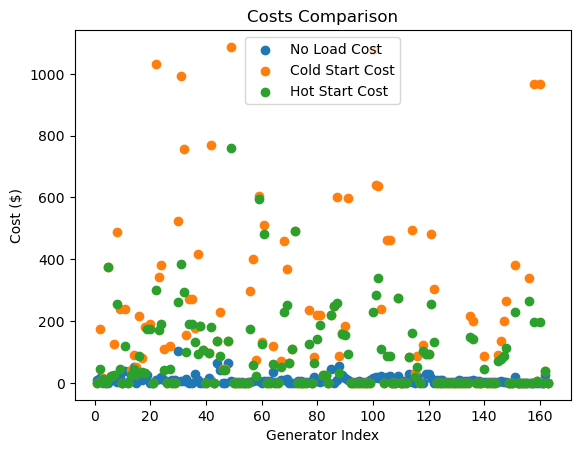

In [57]:
# plot the costs against each other for BIT_ST_coal_costs
# Extract the cost columns from the DataFrame
no_load_cost = BIT_ST_coal_costs_normalized['No Load Cost ($/MW)']
cold_start_cost = BIT_ST_coal_costs_normalized['Cold Start Cost ($/MW)']
hot_start_cost = BIT_ST_coal_costs_normalized['Hot Start Cost ($/MW)']


length = len(BIT_ST_coal_costs)
numbers = np.arange(1, length+1)

# Create the scatter plot
plt.scatter(numbers, no_load_cost, label='No Load Cost')
plt.scatter(numbers, cold_start_cost, label='Cold Start Cost')
plt.scatter(numbers, hot_start_cost, label='Hot Start Cost')

# Set the labels and title
plt.xlabel('Generator Index')
plt.ylabel('Cost ($)')
plt.title('Costs Comparison')
plt.legend()

# Show the plot
plt.show()

Do this in generic scalable code 

In [58]:
# BIT_ST_coal_costs = gen_costs[gen_costs['Generic Name'].isin(BIT_ST_coal['Generic Name'])]
# BIT_ST_coal_costs.drop('Generic Name', axis=1, inplace=True)

In [59]:
# pass in
param_df = BIT_ST_coal
costs_df = BIT_ST_coal_costs_normalized


In [60]:
# Calculate mean of all columns
# process for calculating startup costs
mean_costs = costs_df.mean()
Start_Cost_per_MW = mean_costs.mean()
# Start_Cost_per_MW

In [61]:
param_df

,Generic Name,Energy_Source_1 (Fuel),PRIMEMOVER,NAMEPLATE (MWs),SEASONAL_CAPABILITY (MWs),EFORD,PERC RAMP UP,PERC RAMP DOWN,Economic Minimum (MW),MIN_DOWN_TIME (hr),MIN_RUN_TIME (hr),CO2 rate (lbs/MWh),NOx rate (lbs/MWh),SO2 rate (lbs/MWh),NaN
5,GEN6,BIT,ST,75,86,8.276,0.39579,0.441145,16.5,9,15,2286.5752,3.5949,10.4845,NaN
6,GEN7,BIT,ST,176.8,174,8.276,0.319745,0.35621,38.896,9,15,2286.5752,3.5949,10.4845,NaN
9,GEN10,BIT,ST,81.6,89,8.276,0.375713,0.418762,21.216,9,15,2199.552,4.005,11.7694,NaN
10,GEN11,BIT,ST,81.6,90,8.276,0.379681,0.423181,21.216,9,15,2199.552,4.005,11.7694,NaN
11,GEN12,BIT,ST,176.8,165,8.276,0.305142,0.339959,45.968,9,15,2199.552,4.005,11.7694,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,GEN746,BIT,ST,69.9,69,8.276,0.344588,0.38411,20.271,9,15,2459.4653,3.2075,1.5325,NaN
746,GEN747,BIT,ST,69.9,69,8.276,0.344588,0.38411,15.378,9,15,2459.4653,3.2075,1.5325,NaN
760,GEN761,BIT,ST,135,105,8.276,0.265057,0.295401,39.15,9,15,3291.3034,4.4459,1.6456,NaN
761,GEN762,BIT,ST,135,85,8.276,0.217472,0.242394,39.15,9,15,3291.3034,4.4459,1.6456,NaN


In [62]:
# parameters 
Ramp_Up_Percentage = param_df['PERC RAMP UP'].mean()
Ramp_Dn_Percentage = param_df['PERC RAMP DOWN'].mean()
Min_Power = param_df['Economic Minimum (MW)'].mean()

Down_Time = param_df['MIN_DOWN_TIME (hr)'].min()
Up_Time = param_df['MIN_RUN_TIME (hr)'].min()